In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pickle
import keras

from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing import sequence
from keras import layers

import tensorflow as tf

Parameters

In [2]:
model_path = '../models/tc_model_2_1681327188_tt_1681228271_03_0.7124.h5'
dictionary_path = '../data/small_dictionary_1680888160.pickle'
tokenizer_path = '../models/tokenizer_1681228271.pickle'
places_path = '../data/places_krakow_vectorized_1681330654.pickle'
maxlen = 500

The layers for transformer model

In [3]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, ff_act='relu', ff_reg=None, ff_d=0.25, mh_reg=None, mh_d=0.1, norm_eps=1e-6, **kwargs):
        # initialize super class
        super(TransformerBlock, self).__init__(**kwargs)
        
        # multi head attention
        self.att = layers.MultiHeadAttention(
            num_heads=num_heads, 
            key_dim=embed_dim,
            kernel_regularizer=mh_reg,
            dropout=mh_d
        )
        
        # feed forward network
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation=ff_act, kernel_regularizer=ff_reg), 
            layers.Dense(embed_dim, kernel_regularizer=ff_reg)
        ])
        
        # layer normalizations
        self.layernorm1 = layers.LayerNormalization(epsilon=norm_eps)
        self.layernorm2 = layers.LayerNormalization(epsilon=norm_eps)
        
        # dropout layers
        self.dropout1 = layers.Dropout(ff_d)
        self.dropout2 = layers.Dropout(ff_d)
        
        # remember for serialization
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.ff_act=ff_act
        self.ff_reg=ff_reg
        self.ff_d=ff_d
        self.mh_reg=mh_reg
        self.mh_d=mh_d
        self.norm_eps=norm_eps
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "ff_act": self.ff_act,
            "ff_reg": self.ff_reg,
            "ff_d": self.ff_d,
            "mh_reg": self.mh_reg,
            "mh_d": self.mh_d,
            "norm_eps": self.norm_eps
        })
        return config

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [4]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, embed_reg=None, **kwargs):
        super(TokenAndPositionEmbedding, self).__init__(**kwargs)
        
        # embedding layers
        self.token_emb = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            embeddings_regularizer=embed_reg
        )
        self.pos_emb = layers.Embedding(
            input_dim=maxlen, 
            output_dim=embed_dim,
            embeddings_regularizer=embed_reg
        )
        
        # save for serialization
        self.maxlen = maxlen
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_reg = embed_reg

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "maxlen": self.maxlen,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
            "embed_reg": self.embed_reg
        })
        return config

The method that loads model, tokenizer, vectorized data and the dictionary

In [5]:
def load(model_path, tokenizer_path, places_path, dictionary_path):
    with open(tokenizer_path, 'rb') as file:
        tokenizer = pickle.load(file)
        
    with open(places_path, 'rb') as file:
        places = pickle.load(file)
        
    with open(dictionary_path, 'rb') as file:
        dictionary = pickle.load(file)
        dictionary = {value: key for key, value in dictionary.items()}
        
    model = keras.models.load_model(
        filepath = model_path, 
        custom_objects = {
            "TokenAndPositionEmbedding": TokenAndPositionEmbedding,
            "TransformerBlock": TransformerBlock
        }
    )
    
    return model, tokenizer, places, dictionary

The method takes model, tokenizer & the input text to calculate the interest vector

In [6]:
def calculate_vector(model, tokenizer, text):
    sequences = tokenizer.texts_to_sequences([text])
    x = pad_sequences(sequences, maxlen=maxlen)
    return model.predict(x, verbose=0)[0]

The methods that calculates difference between user profile and the places profiles

In [7]:
def mse(vector, place_vector):
    return np.square(vector - place_vector).mean()

In [8]:
def best_fit_weighted_avg(vector, place_vector, weights=[2, 1.5, 1.5, 1, 1]):
    best_categories = np.argsort(vector)[::-1][0:len(weights)]
    difference = np.abs(place_vector[best_categories] - vector[best_categories])
    return np.average(difference, weights=weights)

The method sorts places by the best fitting ones. It returns the following lists: sorted places, distance values

In [9]:
def sort_places(vector, places, difference_metric=mse):
    buffer = []
    for place in places:
        buffer.append((place, difference_metric(vector, place[10])))
        
    buffer.sort(key=lambda x: x[1])
    
    return zip(*buffer)

### Predict the result on given input text

Set the text for prediction

In [10]:
text = 'What I want to do is to visit some historical places and learn something about the culture of polish people'

Load model & tokenizer

In [11]:
model, tokenizer, places, dictionary = load(model_path, tokenizer_path, places_path, dictionary_path)

Calculate the result vector

In [12]:
result = calculate_vector(model, tokenizer, text)

Sort those places by user interests

In [13]:
#places_sorted, distances = sort_places(result, places, difference_metric=best_fit_weighted_avg)
places_sorted, distances = sort_places(result, places, difference_metric=mse)

### Visualize the result

The method decodes the result vector to human readable form

In [14]:
def visualize_vector(vector, dictionary, text):
    label_weight = [(dictionary[index], weight) for index, weight in enumerate(vector)]
    label_weight.sort(key=lambda x: x[1], reverse=True)
    y, x = zip(*label_weight)
    x = np.array(x)
    x *= 100
    
    plt.figure(figsize=(10, 0.25*len(y)))
    plt.ylabel('Category')
    plt.xlabel('Weight in %')
    plt.title(f'Result for text "{text}"')

    plt.plot(x, y, 'r.', label='Category weight')
    plt.plot(x, y, 'b', label='Category weight (line)', linewidth=0.5)
    plt.xticks(np.arange(0, 101, 10))
    
    plt.legend()
    plt.show()

The method presents the sorting results

In [15]:
def visualize_places(places_sorted, distances, dictionary, text, limit=50):
    y = [f'{(place[1][:37] + "..." if len(place[1]) >= 40 else place[1])} [{dictionary[np.argmax(place[10])]}]' for place in places_sorted]
    x = np.array(distances, dtype='float64')*100
    
    if limit is not None:
        y = y[0:limit+1]
        x = x[0:limit+1]
    
    plt.figure(figsize=(10, 0.25*len(y)))
    plt.ylabel('Place name with best fitting category')
    plt.xlabel('Difference in %')
    plt.title(f'Best fitting places for text "{text}"')

    plt.plot(x, y, 'r.', label='Difference')
    plt.plot(x, y, 'b', label='Difference (line)', linewidth=0.5)
    
    max_val = np.max(x)
    plt.xticks(np.arange(0, int(np.ceil(max_val)), int(np.ceil(max_val))/10))
    
    plt.legend()
    plt.show()

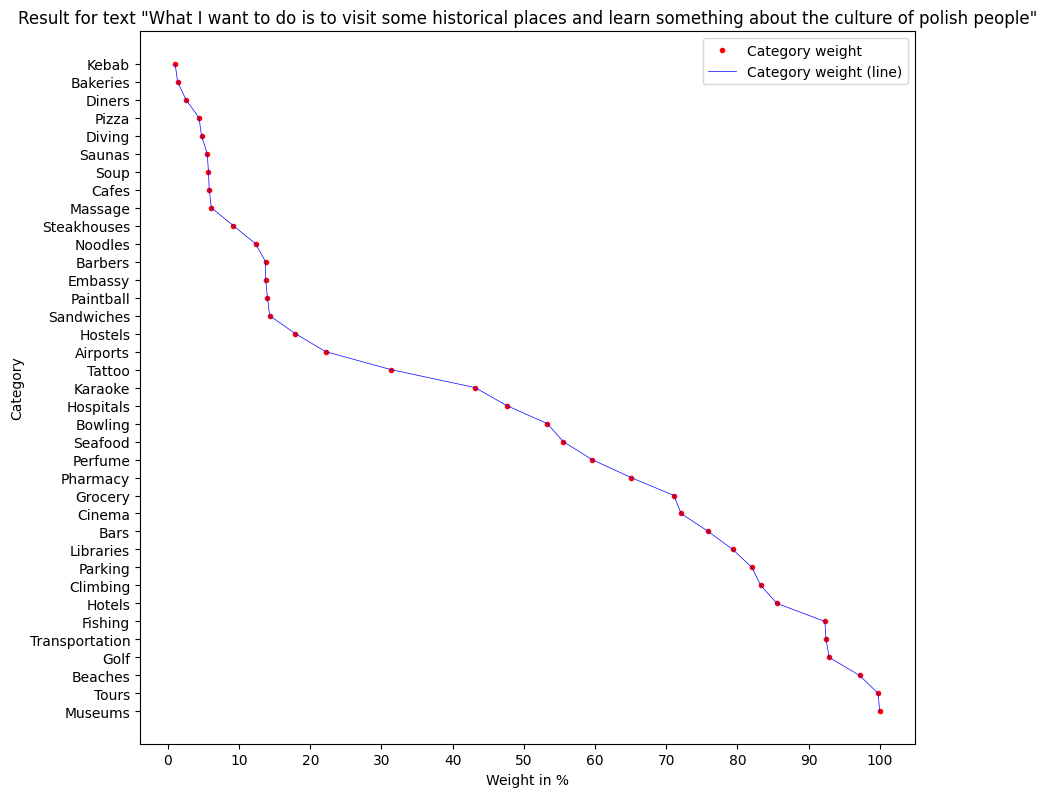

In [16]:
visualize_vector(result, dictionary, text)

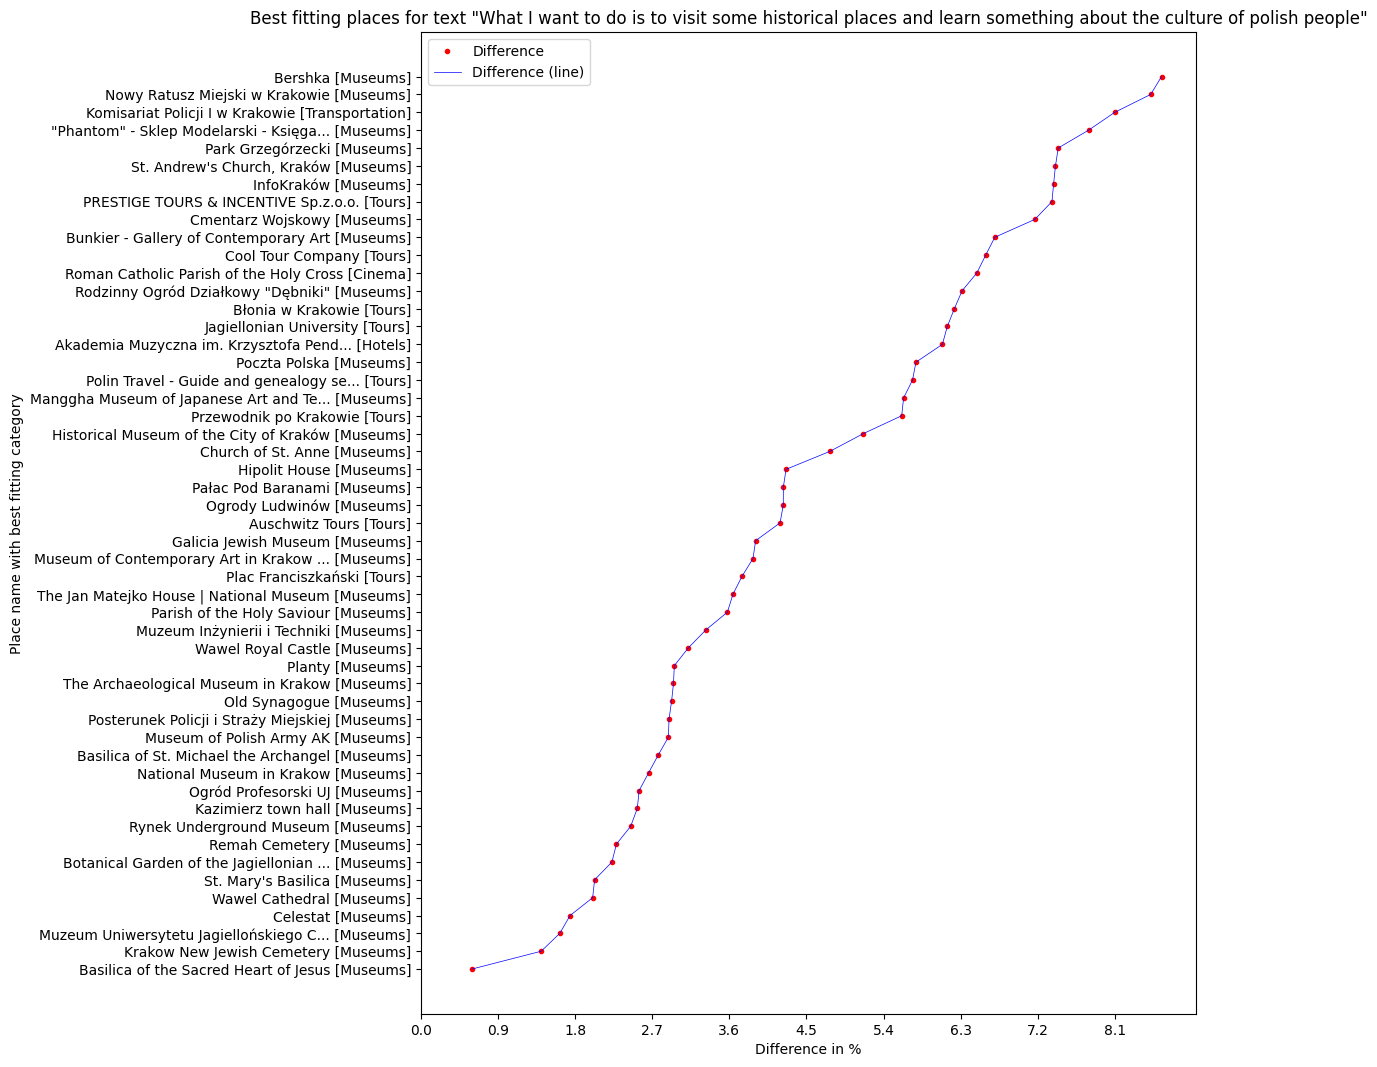

In [17]:
visualize_places(places_sorted, distances, dictionary, text)

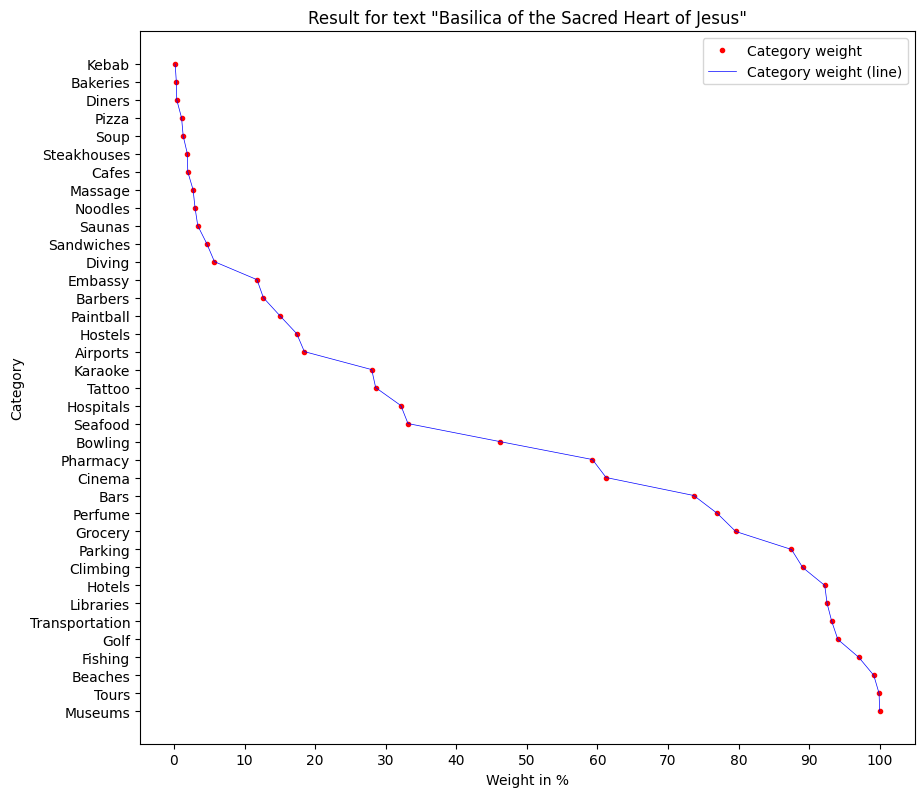

In [18]:
visualize_vector(places_sorted[0][10], dictionary, places_sorted[0][1])